# 1.6 Intro to NLP and Network Analysis

In [16]:
# importlibraries
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import re

In [17]:
# Download English module

!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ----- ---------------------------------- 1.8/12.8 MB 11.2 MB/s eta 0:00:01
     --------------- ------------------------ 5.0/12.8 MB 13.1 MB/s eta 0:00:01
     -------------------- ------------------- 6.6/12.8 MB 11.2 MB/s eta 0:00:01
     ------------------------- -------------- 8.1/12.8 MB 11.7 MB/s eta 0:00:01
     ----------------------------- ---------- 9.4/12.8 MB 9.5 MB/s eta 0:00:01
     ------------------------------------ --- 11.5/12.8 MB 9.5 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 9.0 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [18]:
# Load spacy English module
NER = spacy.load("en_core_web_sm")

# Load Alice in Wonderland book

In [19]:
# load the book 

with open("alice_cleaned.txt", "r", encoding="utf-8") as f:
   raw_text = f.read()

In [20]:
# Clean citations and footnotes
text = re.sub(r"\[\d+\]", "", raw_text)  # Remove footnotes like [96]
text = re.sub(r"\bab[A-Za-z]+\s\d{4}\b", "", text)  # Remove abAuthor 1994
text = re.sub(r"p{1,2}\.?\s?\d+", "", text)  # Remove 'p. 1' or 'pp. 2–3'
text = re.sub(r"[“”\"]", "", text)  # Remove quotation marks
text = re.sub(r"[’‘]", "'", text)  # Normalize apostrophes
text = re.sub(r"\s{2,}", " ", text)  # Remove extra spaces

In [21]:
# Step 3: Save the cleaned version
with open("alice_cleaned_final.txt", "w", encoding="utf-8") as f:
    f.write(text) 

In [22]:
print(text[:500])  # preview the cleaned output

Alices Adventures in Wonderland(also known asAlice in Wonderland) Englishchildrens novelbyLewis Carroll, a mathematicsdonat theUniversity of Oxford. It details the story of a girl namedAlicewho falls through a rabbit hole into a fantasy world ofanthropomorphiccreatures. It is seen as an example of theliterary nonsensegenre. The artist SirJohn Tennielprovided 42 wood-engraved illustrations for the book.
It received positive reviews upon release and is now one of the best-known works ofVictorian l


### Text Preprocessing Observations

Before applying Named Entity Recognition (NER), I examined the scraped text for quality and consistency.

**Key Observations:**
- The raw text contained unnecessary artifacts such as footnote markers like `[96]`, superscripts, and citation formats like `abSmith 1993`.
- Some characters like curly quotes and special symbols were present.
- Country names in the text appeared in various inconsistent formats, e.g., "USA", "U.S.", or "Soviet Union" instead of "United States" or "Russia".

**Actions Taken:**
- Removed citation markers and cleaned up formatting using regular expressions.
- Normalized country names using a dictionary to map variations like "USA" → "United States", "UK" → "United Kingdom", and "USSR" → "Russia".
- Verified that the entity list produced by NER was cleaned and consistent with the country reference list.

This step ensures more accurate country-level relationship extraction in the following steps.

# NER object 

In [25]:
# Step 1: Load cleaned text
with open("alice_cleaned.txt", "r", encoding="utf-8") as f:
    cleaned_text = f.read()

In [26]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(cleaned_text)

# Sentence-Level Entity Extraction

In [27]:
sentences = list(doc.sents)

In [28]:
sentence_entities = []

for sent in sentences:
    entities = [ent.text for ent in sent.ents if ent.label_ == "GPE"]  # GPE = countries, cities, regions
    sentence_entities.append({
        "sentence": sent.text,
        "entities": entities
    })

df_sentences = pd.DataFrame(sentence_entities)
df_sentences.head() 

,sentence,entities
0,Alices Adventures in Wonderland(also known asA...,[Wonderland]
1,"Englishchildrens novelbyLewis Carroll, a mathe...","[theUniversity, Oxford]"
2,It details the story of a girl namedAlicewho f...,[]
3,It is seen as an example of theliterary nonsen...,[]
4,The artist SirJohn Tennielprovided 42 wood-eng...,[]


In [29]:
# Step: Normalize country names using a mapping dictionary
normalization_dict = {
    "USA": "United States",
    "U.S.A.": "United States",
    "U.S.": "United States",
    "UK": "United Kingdom",
    "U.K.": "United Kingdom",
    "USSR": "Russia",
    "Soviet Union": "Russia",
    "North Korea": "Korea, North",
    "South Korea": "Korea, South",
    "Republic of Korea": "Korea, South",
    "Iran": "Iran, Islamic Republic of",
    "Russia": "Russian Federation"
    # Add more mappings if needed
}

def normalize_entities(entities):
    return [normalization_dict.get(ent, ent) for ent in entities]

# Apply normalization
df_sentences["normalized_entities"] = df_sentences["entities"].apply(normalize_entities)

In [30]:
# Normalize named entities
def normalize_entities(entities):
    return [normalization_dict.get(ent.lower(), ent.lower()) for ent in entities]

# Apply normalization (assumes 'entities' column exists)
df_sentences["normalized_entities"] = df_sentences["entities"].apply(normalize_entities)

# Load Countries

In [31]:
countries = [
    "united states", "united kingdom", "china", "russia", "germany", "france",
    "japan", "india", "pakistan", "canada", "italy", "iran", "iraq", "egypt",
    "israel", "spain", "mexico", "brazil", "australia", "afghanistan"
]

In [32]:
normalization_dict = {
    "usa": "united states",
    "uk": "united kingdom",
    "ussr": "russia"
    # Add more if needed
}

def normalize_entities(entities):
    return [normalization_dict.get(ent.lower(), ent.lower()) for ent in entities]

df_sentences["normalized_entities"] = df_sentences["entities"].apply(normalize_entities)

In [33]:
df_sentences_filtered = df_sentences.copy()

df_sentences_filtered["country_entities"] = df_sentences_filtered["normalized_entities"].apply(
    lambda x: [ent for ent in x if ent in countries]
)

In [34]:
df_entities = pd.DataFrame(sentence_entities)

# Optional: save raw entity dataframe
df_entities.to_csv("sentence_entities.csv", index=False)

# Load country list
countries = ['India', 'China', 'France', 'Germany', 'United Kingdom', 'Russia', 'Italy', 'Japan', 'Spain', 'England', 'Pakistan']

# Filter only relevant entities
def filter_to_countries(entity_list):
    return [e for e in entity_list if e in countries]

df_entities["filtered"] = df_entities["entities"].apply(filter_to_countries)

# Preview
df_entities[df_entities["filtered"].apply(lambda x: len(x) > 0)].head() 

,sentence,entities,filtered
163,",Alice in Wonderlandwas named among the icons ...","[Wonderlandwas, England]",[England]
170,A popular figure in Japan sincethe country ope...,[Japan],[Japan]
193,"Although the original production inHamburg, Ge...",[Germany],[Germany]
195,It was performed frequently in England and the...,[England],[England]
198,"Gerald Barry one-actopera,Alices Adventures Un...",[France],[France]


# Create Relationship Pairs

In [35]:
normalization_dict = {
    "usa": "united states",
    "uk": "united kingdom",
    "ussr": "russia"
    # Add more if needed
}

def normalize_entities(entities):
    return [normalization_dict.get(ent.lower(), ent.lower()) for ent in entities]

df_sentences["normalized_entities"] = df_sentences["entities"].apply(normalize_entities)


In [36]:
df_sentences["filtered"] = df_sentences["normalized_entities"].apply(
    lambda x: [ent for ent in x if ent in countries]
)

In [37]:
relationships = []
window_size = 5

for i in range(df_sentences_filtered.index[-1]):
    end_i = min(i + window_size, df_sentences_filtered.index[-1])
    
    countries_window = sum((df_sentences_filtered.loc[i:end_i, "country_entities"]), [])
    
    unique_countries = [countries_window[j] for j in range(len(countries_window))
                        if j == 0 or countries_window[j] != countries_window[j - 1]]

    if len(unique_countries) > 1:
        for idx in range(len(unique_countries) - 1):
            relationships.append({
                "source": unique_countries[idx],
                "target": unique_countries[idx + 1]
            })

relationships_df = pd.DataFrame(relationships)

# Show results
relationships_df.head(10)

,source,target
0,germany,france
1,france,australia
2,france,australia
3,australia,united kingdom
4,france,australia
5,australia,united kingdom
6,australia,united kingdom
7,australia,united kingdom
8,australia,united kingdom
9,germany,united states


# Add Value

In [38]:
# Add a column for value (weight of connection)
relationship_df = pd.DataFrame(relationships)
relationship_df["value"] = 1

# Group by pair
relationship_df = relationship_df.groupby(["source", "target"], as_index=False).sum()
relationship_df.sort_values("value", ascending=False).head(10)

,source,target,value
0,australia,spain,5
1,australia,united kingdom,5
3,france,japan,5
6,japan,australia,5
5,germany,united states,5
7,spain,israel,5
8,united states,france,5
2,france,australia,3
4,germany,france,1


In [49]:
relationships_df.to_csv("country_relationships.csv", index=False)

# Frequency check

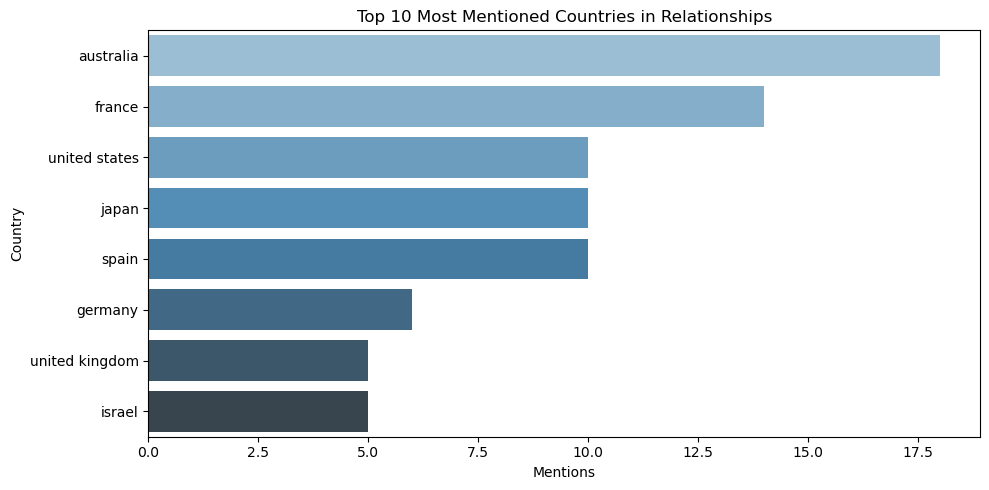

In [37]:
plt.figure(figsize=(10, 5))
sns.barplot(x=top_mentions.values, y=top_mentions.index, palette="Blues_d", hue=top_mentions.index, legend=False)
plt.title("Top 10 Most Mentioned Countries in Relationships")
plt.xlabel("Mentions")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# Heatmap of Relationships (Source vs Target)

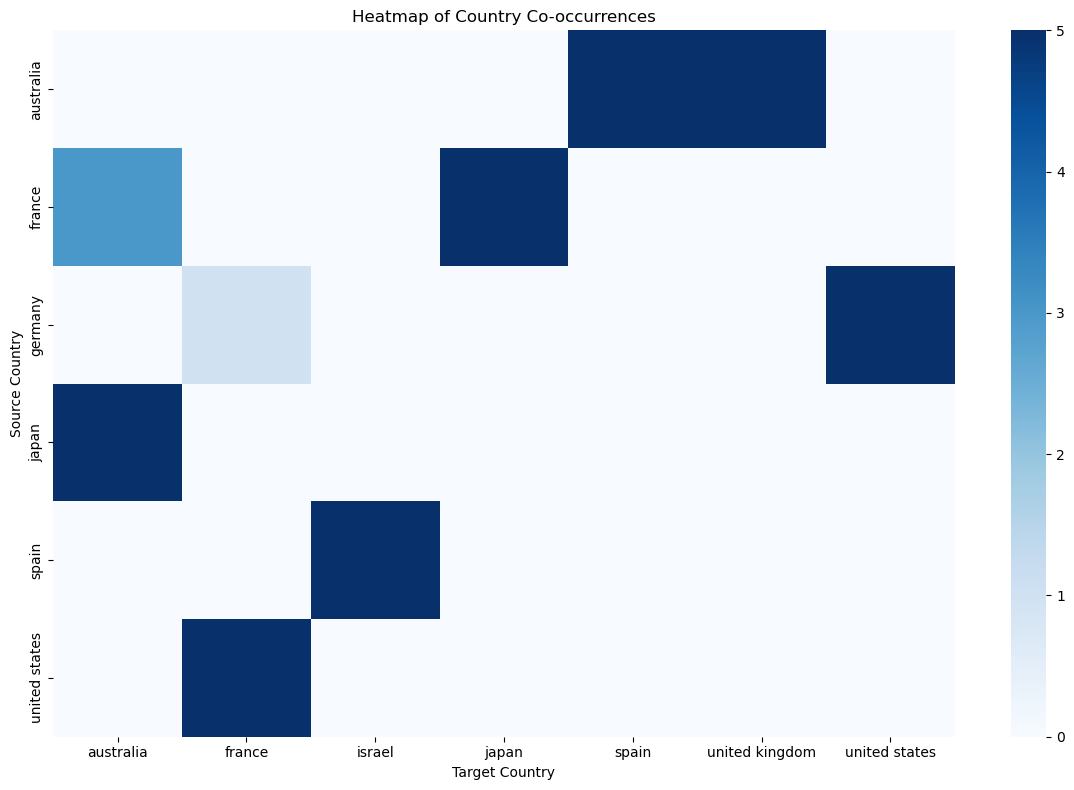

In [44]:
# Create pivot table for heatmap
heatmap_data = relationships_df.pivot_table(index="source", columns="target", values="value", fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="Blues", annot=False)
plt.title("Heatmap of Country Co-occurrences")
plt.xlabel("Target Country")
plt.ylabel("Source Country")
plt.tight_layout()
plt.show()
